In [1]:
# Set google drive folder to working directory

from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('gdrive/My Drive/Colab Notebooks/ml_engineer/unsupervised_learning/algorithms/kmeans_movieLens')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
os.listdir()

['README.txt', '__pycache__', 'data', 'helper.py', 'kmeans_movieLens.ipynb']

In [0]:
import os

data = os.getcwd()+'/data'

if 'data' not in os.listdir():
    !wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -P 'data'
    !unzip './data/ml-latest-small.zip' -d './data'

In [0]:
# ---------------------------- AUXILIAR FUNCTIONS ---------------------------- #
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

def draw_scatterplot(title, x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.xlim(0,5)
    plt.ylim(0,5)
    plt.title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
    plt.plot()

def draw_clusters(title, biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0,5)
    plt.ylim(0,5)
    plt.title(title)
    ax.set_xlabel('Average Sci-Fi Rating')
    ax.set_ylabel('Average Romance Rating')

    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)
    plt.show()
        
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

def sparse_clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    cluster_centers = kmeans.cluster_centers_
    errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data, predictions)]
    return sum(errors)

def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings
    
def get_dataset_3(movies, ratings, genre_ratings):    
    # Extract action ratings from dataset
    action_movies = movies[movies['genres'].str.contains('Action') ]
    # Get average vote on action movies per user
    avg_action_votes_per_user = ratings[ratings['movieId'].isin(action_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
    # Add action ratings to romance and scifi in dataframe
    genre_ratings_3 = pd.concat([genre_ratings, avg_action_votes_per_user], axis=1)
    genre_ratings_3.columns = ['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating']
    
    # Let's bias the dataset a little so our clusters can separate scifi vs romance more easily
    b1 = 3.2
    b2 = 2.5
    biased_dataset_3 = genre_ratings_3[((genre_ratings_3['avg_romance_rating'] < b1 - 0.2) & (genre_ratings_3['avg_scifi_rating'] > b2)) | ((genre_ratings_3['avg_scifi_rating'] < b1) & (genre_ratings_3['avg_romance_rating'] > b2))]
    biased_dataset_3 = pd.concat([biased_dataset_3[:300], genre_ratings_3[:2]])
    biased_dataset_3 = pd.DataFrame(biased_dataset_3.to_records())
    
    return biased_dataset_3

def draw_clusters_3d(title, biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.xlim(0,5)
    plt.ylim(0,5)
    plt.title(title)
    ax.set_xlabel('Average Sci-Fi Rating')
    ax.set_ylabel('Average Romance Rating')

    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3: 
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'], 
                        point['avg_romance_rating'], 
                        s=size, 
                        color=color)
    plt.plot()
    
def draw_movie_clusters(clustered, max_users, max_movies, cmap='viridis'):
    c=1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most max_users users and max_movies movies per cluster.
        # You can change these values to see more users & movies per cluster
        d = clustered[clustered.group == cluster_id].drop(['index', 'group'], axis=1)
        n_users_in_cluster = d.shape[0]
        
        d = sort_by_rating_density(d, max_movies, max_users)
        
        d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
        d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_movies]
        n_users_in_plot = d.shape[0]
        
        # We're only selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
            print('cluster # {}'.format(cluster_id))
            print('# of users in cluster: {}.'.format(n_users_in_cluster), '# of users in plot: {}'.format(n_users_in_plot))
            fig = plt.figure(figsize=(15,4))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = d.columns.str[:40]

            ax.set_yticks(np.arange(d.shape[0]) , minor=False)
            ax.set_xticks(np.arange(d.shape[1]) , minor=False)

            ax.set_xticklabels(labels, minor=False)
                        
            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=0, vmax=5, aspect='auto', cmap=cmap)

            ax.set_xlabel('movies')
            ax.set_ylabel('User id')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
            cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', labelbottom='off', labelleft='off') 

            plt.show()
                
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1 - Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2 - Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3 - Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection

def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies
    
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True, cmap='viridis'):
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto', cmap=cmap)

    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

    plt.show()
    
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset = genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# K-Means Clustering of Movie Ratings
Let's explore the similarities and differences in people's tastes in movies based on how they rate different movies. Can understanding these ratings contribute to a movie recomendation system for users?

The data comes from [MovieLens](https://movielens.org/) [user rating dataset](https://grouplens.org/datasets/movielens/). Let's start with how ratings of genres compare to each other.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
import helper

# Import the movies dataset
movies = pd.read_csv('./data/ml-latest-small/movies.csv')

In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# Import ratings dataset
ratings = pd.read_csv('./data/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
print('The dataset contains ', len(ratings), ' ratings of ', len(movies), ' movies')

The dataset contains  100836  ratings of  9742  movies


## Romance vs. Sci-fi

In [9]:
# Calculate the average rating of romance and sci-fi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
userId,,
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


Let bias this dataset a little by removing people who like both sci-fi and romance, just so that our clusters tend to define them as liking one genre more than the other.

In [10]:
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

print('Number of records: ', len(biased_dataset))
biased_dataset.head()

Number of records:  162


,userId,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


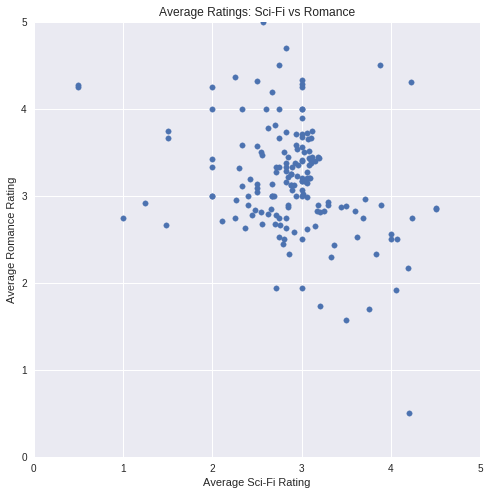

In [11]:
%matplotlib inline

draw_scatterplot('Average Ratings: Sci-Fi vs Romance', biased_dataset['avg_scifi_rating'], 'Average Sci-Fi Rating', biased_dataset['avg_romance_rating'],'Average Romance Rating')

In [12]:
# Turn dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values
X[:5]

array([[4.2 , 0.5 ],
       [2.83, 3.38],
       [2.5 , 3.09],
       [3.15, 2.65],
       [3.  , 3.17]])

* Import [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
* Prepare KMeans with n_clusters = 2
* Pass the dataset **X** to KMeans' fit_predict method and retrieve the clustering labels into *predictions*

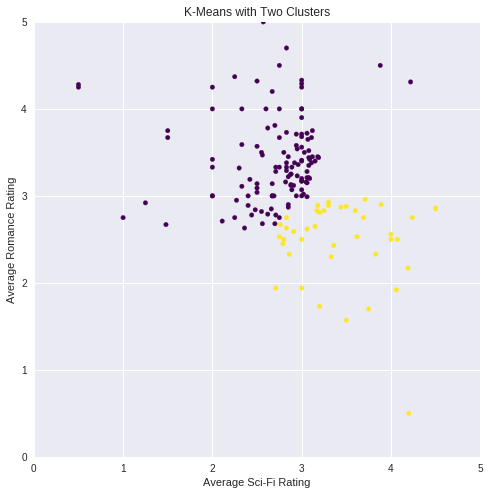

In [13]:
# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans with two clusters
kmeans_1 = KMeans(n_clusters = 2, random_state = 42)

# Cluster the dataset
pred = kmeans_1.fit_predict(X)

# Plot
draw_clusters('K-Means with Two Clusters', biased_dataset, pred)

We can see that the groups are mostly based on how each person rated romance movies. If their average rating movies is over 3 stars, then they belong to on group. Otherwise, they belong to other group.
Let's break them down into three groups

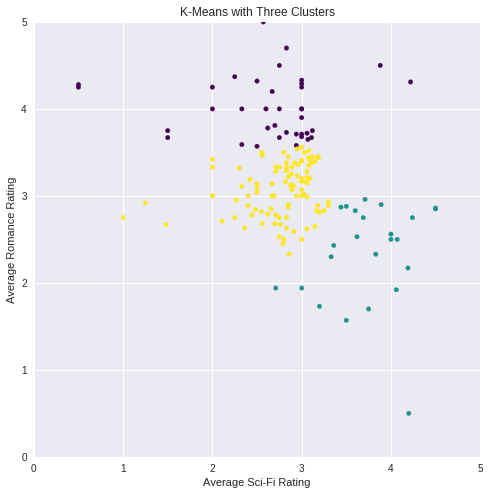

In [14]:
# Create an instance of KMeans with three clusters
kmeans_2 = KMeans(n_clusters = 3, random_state = 42)

# Cluster the dataset
pred_2 = kmeans_2.fit_predict(X)

# Plot
draw_clusters('K-Means with Three Clusters', biased_dataset, pred_2)

Now the average sci-fi rating is starting to come into play. The groups are:
* people who like romance but not sci-fi
* people who like sci-fi but not romance
* people who like both

Let's add one more group

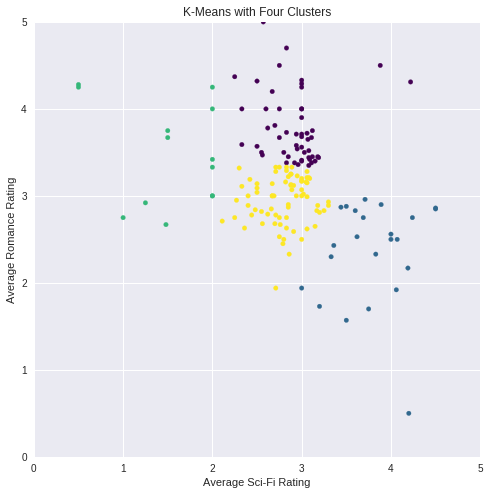

In [15]:
# Create an instance of KMeans to find four clusters
kmeans_3 = KMeans(n_clusters = 4, random_state = 42)

# Cluster the dataset
pred_3 = kmeans_3.fit_predict(X)

# Plot
draw_clusters('K-Means with Four Clusters', biased_dataset, pred_3)

We can see that the more clusters we break our dataset down into, the more similar tastes of the population of each cluster to each other.

## Choosing K
There are [several](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set) ways if choosing the number of clusters, k. We'll look at a simple one called **`the elbow method`**. It works by plotting the ascend values of k versus the total error calculated using that k.

One way to calculate the error is `squared error`. Say we're calculating the error for k = 2. We'd have two clusters each having one "centroid" point. For each point in our dataset, we'd subtract its coordinates from the centroid of the cluster it belongs to. We then square the result of that subtraction (to get rid of the negative values), and sum the values. This would leave us with an error for each point. If we sum these error values, we'd get the total error for all points when k = 2.

In [16]:
# Choose the range of k values to test.
possible_k_values = range(2, len(X) + 1, 5)

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k,X) for k in possible_k_values]

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  return_n_iter=True)


In [17]:
# Values of K vs. the silhouettescore of running K-Means with that value of k
list(zip(possible_k_values, errors_per_k))[::5]

[(2, 0.37651376343962917),
 (27, 0.4133250373007376),
 (52, 0.41670259287536177),
 (77, 0.37727108431895684),
 (102, 0.3226665698671248),
 (127, 0.22189867403680277),
 (152, 0.10678588096581217)]

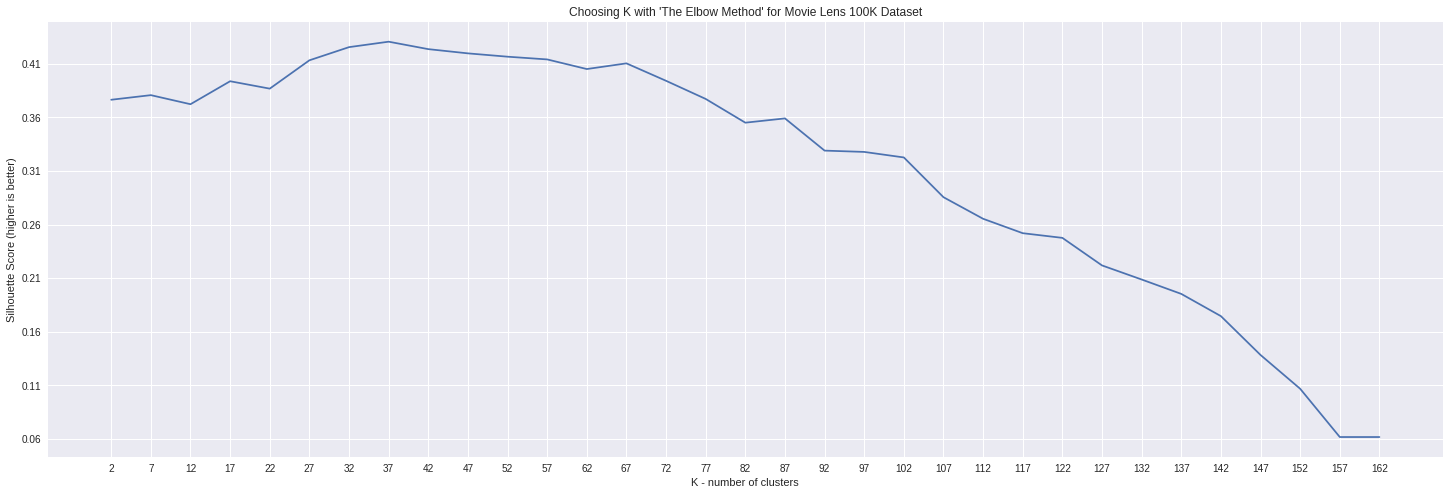

In [18]:
# Plot the each value of K vs. the silhouette score of running K-means with that value of k
fig, ax = plt.subplots(figsize = (25,8))
plt.title('Choosing K with \'The Elbow Method\' for Movie Lens 100K Dataset')
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values) + 1, 5.0)
ax.set_xticks(xticks, minor = False)
ax.set_xticks(xticks, minor = True)
ax.xaxis.grid(True, which = 'both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor = False)
ax.set_yticks(yticks, minor = True)
ax.yaxis.grid(True, which = 'both')

Looking at this graph, good choices for k include 7, 32, 37, amongst other values(with a slight variation betwen different runs). Increasing the number of clusters (k) beyond that range starts to result in worse clusters (according to Silhouette score)

Let's pick k = 7 because it's easier to visualize:

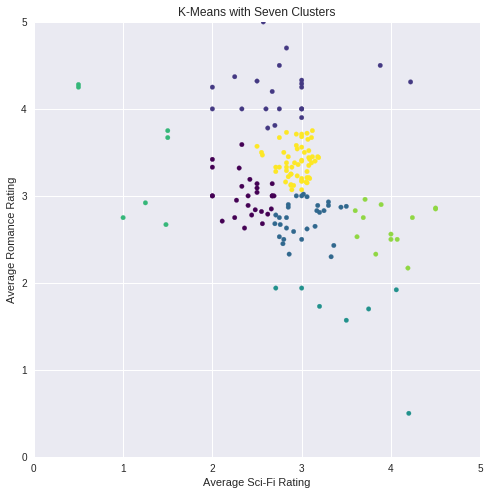

In [19]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters = 7, random_state = 42)

# Cluster the dataset
pred_4 = kmeans_4.fit_predict(X)

# Plot
draw_clusters('K-Means with Seven Clusters', biased_dataset, pred_4)

Note: As you try to plot larger values of k (more than 10), you'll have to make sure your plotting library is not reusing colors between clusters. For this plot, we had to use the [matplotlib colormap](https://matplotlib.org/examples/color/colormaps_reference.html) 'Accent' because other colormaps either did not show enough contrast between colors, or were recycling colors past 8 or 10 clusters.

## Throwing some Actiom into the mix
So far, we've only been looking at how users rated romance and sci-fi movies. Let's throw another genre into the mix. Let's add the Action genre.

In [20]:
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi', 'Action'],
                                                                    ['avg_romance_rating','avg_scifi_rating','avg_action_rating'])

biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()

print('Number of records: ', len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,userId,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


In [0]:
X_with_action = biased_dataset_3_genres[['avg_romance_rating','avg_scifi_rating','avg_action_rating']].values

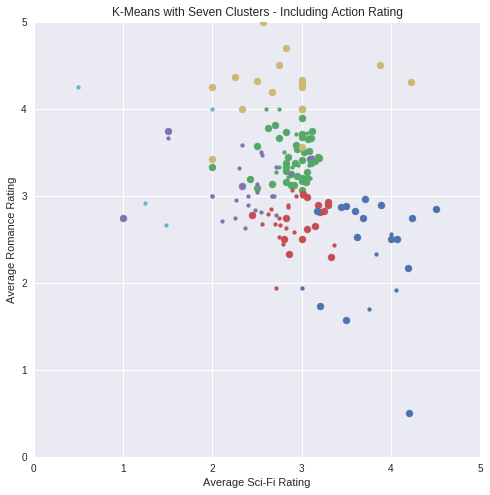

In [22]:
# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters = 7, random_state = 42)

# Cluster the dataset
pred_5 = kmeans_5.fit_predict(X_with_action)

# Plot
draw_clusters_3d('K-Means with Seven Clusters - Including Action Rating', biased_dataset_3_genres, pred_5)

We're still using the x and y axes for sci-fi and romance respectively. We are using the soze of the dot to roughly code the `action` rating (large dot for avg ratings over than 3, small dot otherwise).

We can start seeing the added genre changing how the users are clustered. The more data we give to k-means, the more similar the tastes of the people in each group would be. Unfortunately, thoughm we lose the ability to visualize what's going on the past two or three dimensions if we continue to plot it this way.

## Movie-level Clustering
Now that we've established some trust in how k-means clusters users based on their genre tastes, let's take a bigger bite and look at how users rated individual movies.

**Obs.:** our dataset is very big, so, let's choose the most-rated movies vs users with the most ratings.

In [23]:
# Merge the two tables then pivot to have Users X Movies dataframe
ratings_title      = pd.merge(ratings, movies[['movieId','title']], on = 'movieId')
user_movie_ratings = pd.pivot_table(ratings_title, index = 'userId', columns = 'title', values = 'rating')

print('Dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6,:10]

Dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dominance of NaN values presents the first issue. Most users have not rated and watched most movies. Datasets like this are called `sparsed` because only a small number of cells have values.

To get around this, let's sort by the most rated movies, and the users who have rated the most number of movies. That will present a more 'dense' region when we peak at the top of the dataset.


In [24]:
n_movies = 30
n_users  = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('Dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

Dataset dimensions:  (18, 30)


title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),...,Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),Saving Private Ryan (1998),"Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)"
413,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,...,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.0,5.0,3.0
589,5.0,4.5,4.5,3.5,4.0,5.0,4.0,4.0,4.5,5.0,...,4.5,5.0,4.0,3.5,4.0,5.0,4.5,4.0,4.0,3.5
473,3.0,5.0,4.0,4.5,4.5,4.0,4.5,3.0,4.0,5.0,...,4.0,5.0,5.0,4.0,3.0,5.0,5.0,4.0,4.0,5.0
479,5.0,5.0,4.0,4.5,5.0,4.5,5.0,5.0,4.5,5.0,...,3.5,5.0,3.5,4.5,4.5,4.5,4.0,4.0,4.0,4.0
67,3.5,3.0,2.0,3.5,4.5,5.0,3.5,2.5,3.5,4.0,...,5.0,4.0,4.5,4.0,4.0,4.0,4.5,3.5,2.5,2.5


Let's also establish a good way for visualizing these ratings so we can attempt to visually recognize the ratings (and later, clusters) when we look at bigger subsets. Let's use colors instead of the number ratings

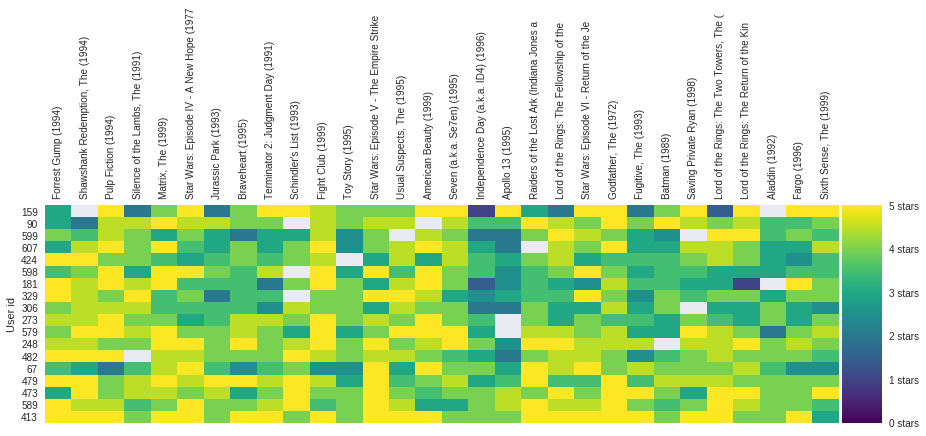

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
axis_labels = True
# Reverse to match the order of the printed dataframe
    
fig = plt.figure(figsize=(15,4))
ax = plt.gca()

# Draw heatmap
heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto', cmap = 'viridis')

if axis_labels:
    ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
    ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    labels = most_rated_movies_users_selection.columns.str[:40]
    ax.set_xticklabels(labels, minor=False)
    ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
    plt.setp(ax.get_xticklabels(), rotation=90)
else:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
ax.grid(False)
ax.set_ylabel('User id')

# Separate heatmap from color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Color bar
cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

plt.show()

Each column is a movie and each row is an user. The color of the cell is how the user rated that movie based on the scale on the right of the graph

Notice how some cells are white, this means the respective user did not rate that movie. Real-world datasets can often be sparse and not have a value in each cell of the dataset. This makes it less straightforward to cluster users directly by their movie ratings as k-means generally does not like missing values.

For performance reasons, we'll only use ratings for 1k movies (out of the 9k+ available in the dataset.)

In [26]:
user_movie_ratings   = pd.pivot_table(ratings_title, index = 'userId', columns = 'title', values = 'rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)
most_rated_movies_1k.head()

title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),...,Scary Movie 2 (2001),About Schmidt (2002),21 Jump Street (2012),"Cider House Rules, The (1999)",Death Proof (2007),Moonraker (1979),"Virgin Suicides, The (1999)",¡Three Amigos! (1986),Waking Ned Devine (a.k.a. Waking Ned) (1998),Jacob's Ladder (1990)
0,4.0,NaN,3.0,4.0,5.0,5.0,4.0,4.0,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
1,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1.0,5.0,1.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
4,NaN,3.0,5.0,NaN,NaN,NaN,NaN,4.0,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To have sklearn run k-means clustering to a dataset with missing values like this, we will first cast it to the [sparse csr matrix](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.sparse.csr_matrix.html) type defined in the SciPi library. To convert from a pandas dataframe to a sparse matrix, we'll have to convert to `SparseDataFrame`, then use pandas' `to_coo()` method for the conversion.

> Note: `to_coo()` was only added in later versions of pandas. If you run in to an error with the next cell, make sure pandas is up to date.

In [0]:
sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_movies_1k).to_coo())

## Let's Cluster
With k-means, we have to specify k, the number of clusters. Let's arbitrary try k = 20 (A better way to pick k is using the elbow method. That would take some processing time to run, however):

In [0]:
# Create an instance of of KMeans to find twenty clusters
pred = KMeans(n_clusters = 20, random_state = 42, algorithm = 'full').fit_predict(sparse_ratings)

To visualize some of these clusters, we'll plot each cluster as a heat map

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


cluster # 12
# of users in cluster: 33. # of users in plot: 33


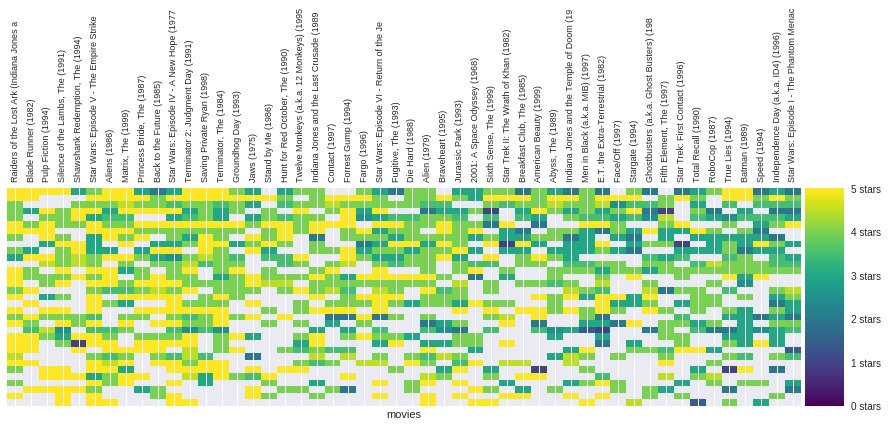

cluster # 19
# of users in cluster: 211. # of users in plot: 70


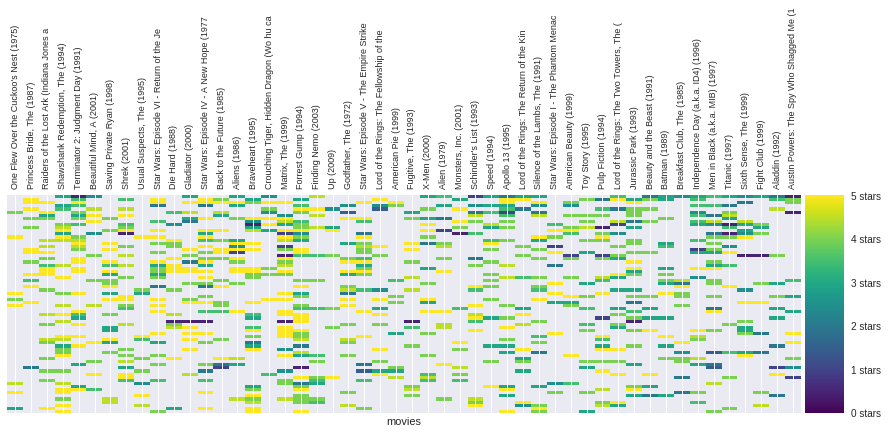

cluster # 16
# of users in cluster: 39. # of users in plot: 39


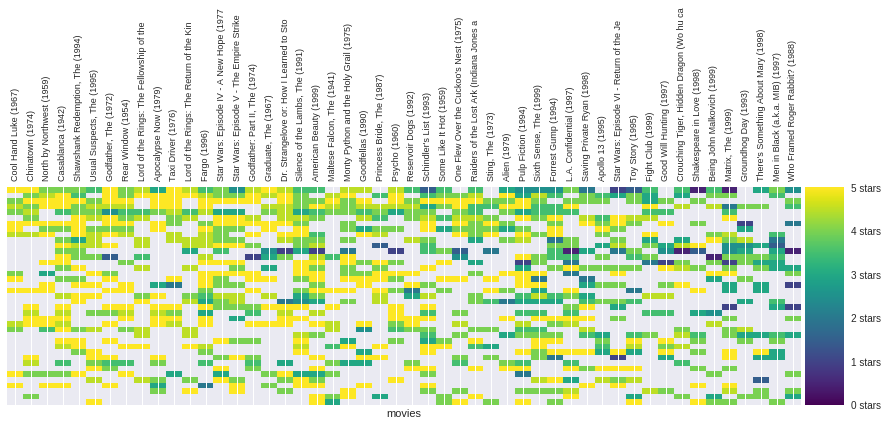

cluster # 3
# of users in cluster: 85. # of users in plot: 70


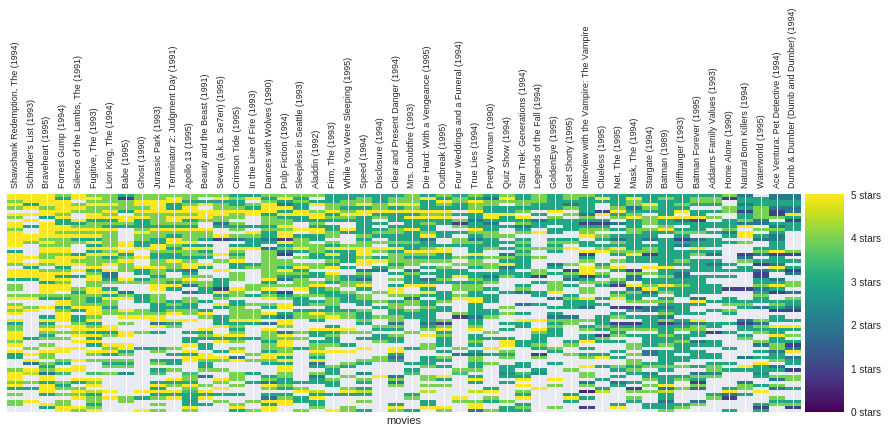

cluster # 4
# of users in cluster: 23. # of users in plot: 23


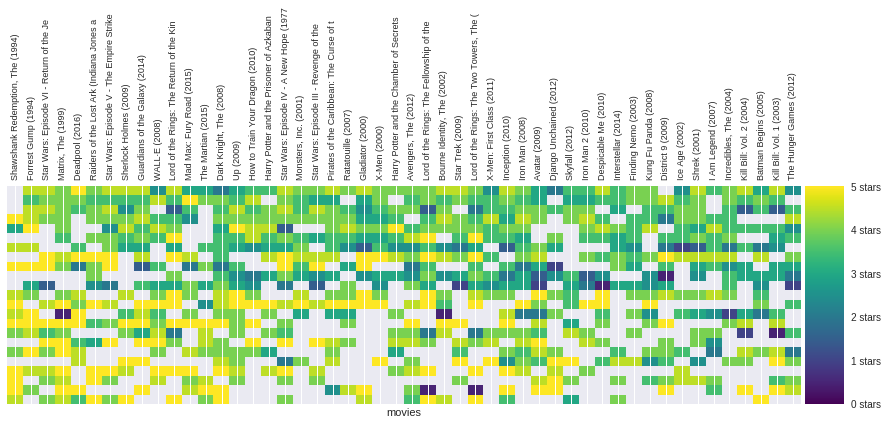

cluster # 17
# of users in cluster: 12. # of users in plot: 12


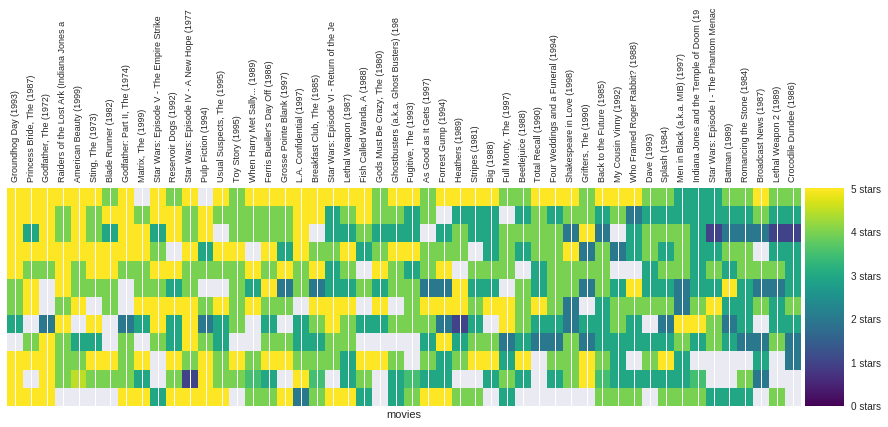

cluster # 5
# of users in cluster: 94. # of users in plot: 70


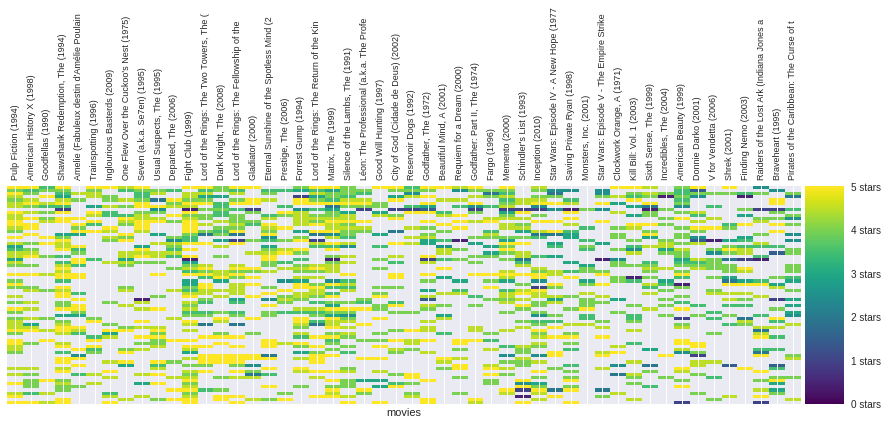

cluster # 10
# of users in cluster: 29. # of users in plot: 29


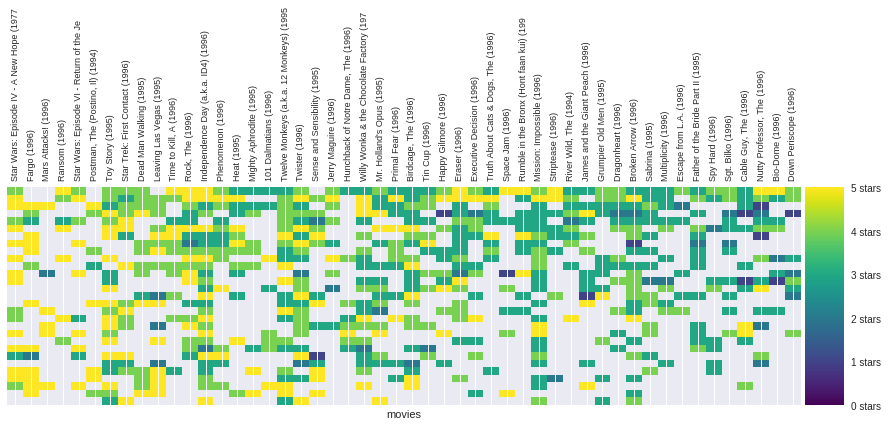

cluster # 7
# of users in cluster: 31. # of users in plot: 31


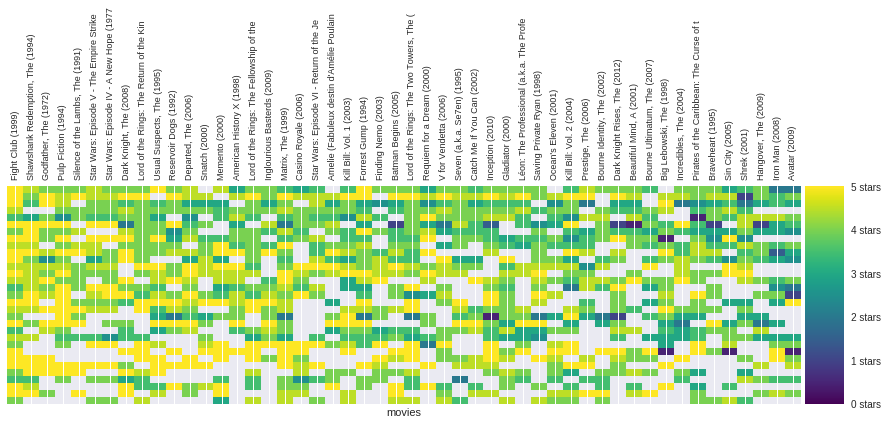

cluster # 6
# of users in cluster: 10. # of users in plot: 10


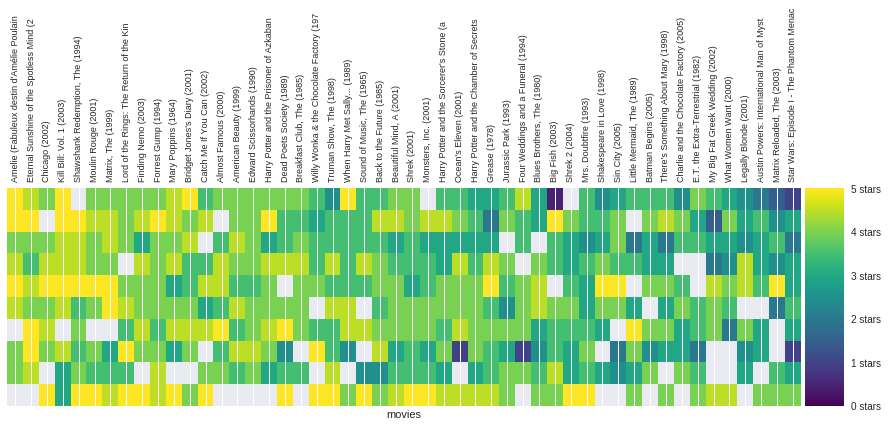

In [29]:
max_users  = 70
max_movies = 50

clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':pred})], axis = 1)

draw_movie_clusters(clustered, max_users, max_movies)

There are several things to note here:
* The more similar the ratings in a cluster are, the more **vertical** lines in similar colours you'll be able to trace in that cluster.
* It's super interesting to spot trends in clusters:
  * Some clusters are more sparse than others, containing people who probably watch are rate less movies than in other clusters.
  * Some clusters are mostly yellow and bring together people who really love a certain group of movies. Other clusters are mostly green or navy blue meaning they contain people who agree that a certain set of movies deserves 2-3 stars.
  * Note how the movies change in every cluster. The graph filters the data to only show the most ratedmovies, and then sorts them by average rating.
* It's easy to spot **horizontal** lines with similar colors, these are users without a lot of variety in their ratings. This is likely one of the reasons of Netflix switching from a stars-based ratings to a thumbs-up/thumbs-down rating. A rating of four stars means different things to different people.
* We did a few things to make the clusters visible (filtering/sorting/slicing). This is because datasets like this are "sparse" and most cells do not have a value (because most people did not watch most movies).

---

## Prediction
Let's pick a cluster and a specific user and see what useful things this clustering will allow us to do.

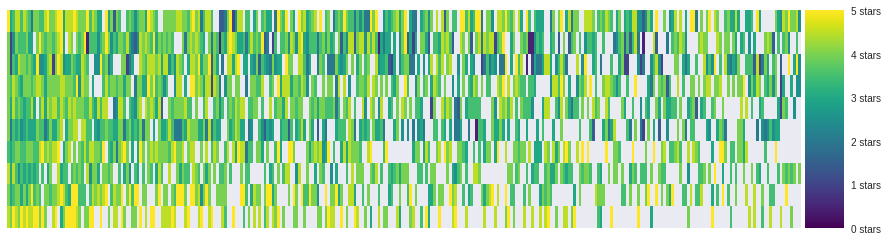

In [30]:
# Pick a cluster ID from the clusters above
cluster_number = 6

# Let's filter to only see the region of the dataset with the most number of values
n_users  = 75
n_movies = 300
cluster  = clustered[clustered.group == cluster_number].drop(['index','group'], axis = 1)

cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels = False)

And the actual ratings in the cluster look like this:

In [31]:
cluster.fillna('').head()

,Forrest Gump (1994),Star Wars: Episode I - The Phantom Menace (1999),"Truman Show, The (1998)","Beautiful Mind, A (2001)",Back to the Future (1985),Mrs. Doubtfire (1993),Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),Shrek (2001),Harry Potter and the Chamber of Secrets (2002),Grease (1978),...,"Godfather, The (1972)",Chicken Run (2000),American Pie 2 (2001),"Hitchhiker's Guide to the Galaxy, The (2005)",300 (2007),Adaptation (2002),"Terminal, The (2004)",Alice in Wonderland (1951),Willow (1988),"Jungle Book, The (1994)"
5,5.0,3.0,3.5,4.5,4.5,3.5,4.5,4.0,3.5,2.0,...,4,3,2.5,4.5,4,5,4,4,4.5,2.5
6,4.0,1.0,2.5,4.0,3.5,3.5,3.5,4.0,3.0,3.0,...,,3.5,,3.5,4,2.5,,,3.5,
8,4.0,1.0,3.5,3.0,4.5,4.0,4.0,3.5,4.0,3.5,...,4,,1.5,,,5,,3,5,2.5
9,4.0,3.5,4.5,4.0,3.5,3.0,4.0,4.0,4.0,3.5,...,4,,1,3,,,3,,2.5,2.5
7,4.0,3.0,4.5,3.5,4.0,3.5,3.0,3.5,3.5,4.5,...,,3,1,4,3.5,,,2.5,,


Pick a blank cell from the table. It's blank because that user did not rate that movie. Can we predict whether she would like it or not? Since the user is in a cluster of users that seem to have similar taste, we can take the average of the votes for that movie in this cluster, and that would be a reasonable predicition for much she would enjoy the film.

In [32]:
# Pick a movie from the table above to create a subset
movie_name = 'Forrest Gump (1994)'

cluster[movie_name].mean()

4.15

And this would be our prediction for how she'd rate the movie.

## Recommendation
Let's reiterate what we did in the previous step. We have used k-means to cluster users according to their ratings. This lead us to clusters of users with similar ratings and thus generally a similar taste in movies. Based on this, when one user did not have a rating for a certain movie  we averaged the ratings of all the other users in the cluster, and that was our guess to how this one user would like the movie.

Using this logic, if we calculate the average score in this cluster for every movie, we'd have an understanding for how this 'taste cluster' feels about each movie in the dataset. 


In [33]:
# The average rating of 20 movies as rated by the users in the cluster.
cluster.mean().head(20)

Forrest Gump (1994)                                                                               4.150000
Star Wars: Episode I - The Phantom Menace (1999)                                                  2.650000
Truman Show, The (1998)                                                                           3.850000
Beautiful Mind, A (2001)                                                                          3.800000
Back to the Future (1985)                                                                         3.800000
Mrs. Doubtfire (1993)                                                                             3.500000
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)    3.700000
Shrek (2001)                                                                                      3.800000
Harry Potter and the Chamber of Secrets (2002)                                                    3.650000
Grease (1978)                        

This becomes really useful for us because we can now use it as a recommendation engine that enables our users to discover movies they're likely to enjoy.

When a user logs in to our app, we can now show them recommendations that are appropriate to their taste. The formula for these recommendations is to select the cluster's highest-rated movies that the user did not rate yet.

In [34]:
# Look at the table above outputted by the command "cluster.fillna('').head()" 
# and pick one of the user ids (the first column in the table)
user_id = 8

# Get all this user's ratings
user_2_ratings = cluster.loc[user_id,:]

# Which movies did they not rate? (We do not want to recommend movies they've already rated)
user_2_unrated_movies = user_2_ratings[user_2_ratings.isnull()]

# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis = 1, join = 'inner').loc[:,0]

# Sorting by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending = False)[:20]

Usual Suspects, The (1995)                                        4.500000
Some Like It Hot (1959)                                           4.300000
Prestige, The (2006)                                              4.200000
Harry Potter and the Deathly Hallows: Part 1 (2010)               4.200000
Monty Python's Life of Brian (1979)                               4.166667
Good Will Hunting (1997)                                          4.166667
Lost in Translation (2003)                                        4.166667
Donnie Darko (2001)                                               4.100000
Ratatouille (2007)                                                4.100000
(500) Days of Summer (2009)                                       4.100000
Harry Potter and the Deathly Hallows: Part 2 (2011)               4.100000
Inception (2010)                                                  4.083333
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)    4.083333
Juno (2007)              

And these are our top 20 recommendations to the user!

## More on Collaborative Filtering
* This is a simplistic recommendation engine that shows the most basic idea of "collaborative filtering". There are many heuristics and methods to improve it. [The Netflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize) tried to push the envelope in this area by offering a prize of US$1,000,000 to the recommendation algorithm that shows the most improvement over Netflix's own recommendation algorithm.
* That prize was granted in 2009 to a team called "BellKor's Pragmatic Chaos". [This paper](http://www.netflixprize.com/assets/GrandPrize2009_BPC_BigChaos.pdf) shows their approach which employed an ensemble of a large number of methods. 
* [Netflix did not end up using this \$1,000,000 algorithm](https://thenextweb.com/media/2012/04/13/remember-netflixs-1m-algorithm-contest-well-heres-why-it-didnt-use-the-winning-entry/) because their switch to streaming gave them a dataset that's much larger than just movie ratings -- what searches did the user make? What other movies did the user sample in this session? Did they start watching a movie then stop and switch to a different movie? These new data points offered a lot more clues than the ratings alone.

## Take it Further

* This notebook showed user-level recommendations. We can actually use the almost exact code to do item-level recommendations. These are recommendations like Amazon's "Customers who bought (or viewed or liked) this item also bought (or viewed or liked)". These would be recommendations we can show on each movie's page in our app. To do this, we simple transpose the dataset to be in the shape of Movies X Users, and then cluster the movies (rather than the users) based on the correlation of their ratings.
* We used the smallest of the datasets Movie Lens puts out. It has 100,000 ratings. If you want to dig deeper in movie rating exploration, you can look at their [full dataset](https://grouplens.org/datasets/movielens/) containing 24 million ratings.
